<a href="https://colab.research.google.com/github/KanVux/Spam_Email_Detection/blob/main/RNN-Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Thu thập dữ liệu

In [ ]:
!pip install tensorflow
!pip install transfomer
!pip install scikeras

ERROR: Could not find a version that satisfies the requirement transfomer (from versions: none)
ERROR: No matching distribution found for transfomer


In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Load file csv vào một dataframe và hiển thị các mẫu email đầu của dataset
df = pd.read_csv('/content/drive/MyDrive/NienLuan/Dataset/spam_ham_dataset.csv')
df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [ ]:
# Có một cột không tên chỉ có số tăng dần -> không hữu ích -> xóa bỏ
columns_need_to_drop = ['Unnamed: 0']
df.drop(columns_need_to_drop, axis=1, inplace=True)
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
# Kiểm tra có các email bị trùng nên cần được xóa
df[df.duplicated()]
# Loại bỏ các email bị trùng
df.drop_duplicates(inplace=True)

label
ham     3531
spam    1462
Name: count, dtype: int64


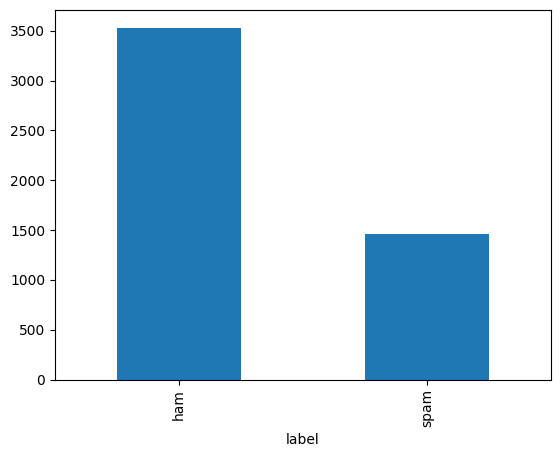

In [ ]:
# Kiểm tra số lượng email có ích (ham) và email spam
df["label"].value_counts().plot(kind="bar");
dff = df["label"].value_counts()
print(dff)

In [ ]:
# X = nội dung email (input: nội dung feed cho các model)
X = df['text']
# y = label_num (output: lớp cần được phân loại)
y = df['label_num']

print(X,y)

0       Subject: enron methanol ; meter # : 988291\r\n...
1       Subject: hpl nom for january 9 , 2001\r\n( see...
2       Subject: neon retreat\r\nho ho ho , we ' re ar...
3       Subject: photoshop , windows , office . cheap ...
4       Subject: re : indian springs\r\nthis deal is t...
                              ...                        
5165    Subject: fw : crosstex energy , driscoll ranch...
5166    Subject: put the 10 on the ft\r\nthe transport...
5167    Subject: 3 / 4 / 2000 and following noms\r\nhp...
5169    Subject: industrial worksheets for august 2000...
5170    Subject: important online banking alert\r\ndea...
Name: text, Length: 4993, dtype: object 0       0
1       0
2       0
3       1
4       0
       ..
5165    0
5166    0
5167    0
5169    0
5170    1
Name: label_num, Length: 4993, dtype: int64


## Tiền xử lý dữ liệu (Preprocessing)

In [ ]:
!pip install nltk

In [ ]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Tải dữ liệu NLTK cần thiết
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Lấy các từ dừng (stopwords) trong tiếng Anh
stop_word = set(stopwords.words('english'))

# Khai báo bổ đề ngôn ngữ
lemmatizer = WordNetLemmatizer()

# Loại bỏ các chữ cái lặp lại liên tiếp trong từ
def remove_duplicate_letters(text):
    """Loại bỏ các chữ cái lặp lại liên tiếp trong một từ."""
    if not text:
        return ""
    result = text[0]
    for char in text[1:]:
        if char != result[-1]:
            result += char
    return result

# Tiền xử lý dữ liệu
def preprocess_text(text):
    """Tiền xử lý chuỗi văn bản."""
    # Đổi toàn bộ chữ thành chữ thường
    text = text.lower()
    # Loại bỏ các dấu câu và ký tự đặc biệt
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text)
    # Loại bỏ các ký tự số
    text = re.sub(r'\d+', '', text)
    # Áp dụng hàm loại bỏ chữ cái lặp lại
    text = ' '.join([remove_duplicate_letters(word) for word in text.split()])
    # Tokenize từ và loại bỏ các từ dừng (stopwords)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_word]
    # Chuyển các từ về dạng nguyên bản (lemmatize)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Trả về chuỗi đã tiền xử lý
    return ' '.join(tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['cleaned_text'] = df['text'].apply(preprocess_text)
X=df['cleaned_text']
df.head()

,label,text,label_num,cleaned_text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,subject enron methanol meter folow note gave m...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,subject hpl nom january se atached file hplnol...
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,subject neon retreat ho ho ho around wonderful...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop window ofice cheap main tren...
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,subject indian spring deal bok teco pvr revenu...


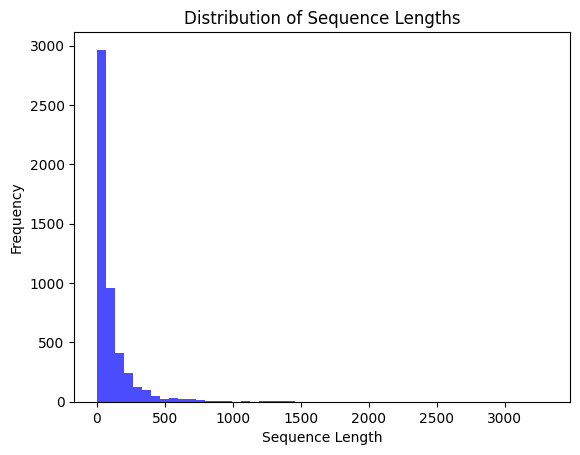

Max length: 3318
Mean length: 100.86441017424394
Median length: 50.0
90th percentile: 237.80000000000018


In [ ]:
# Tính độ dài của từng chuỗi
sequence_lengths = [len(seq.split()) for seq in X]  # X là danh sách các chuỗi văn bản

# Vẽ biểu đồ phân phối độ dài chuỗi
plt.hist(sequence_lengths, bins=50, color='blue', alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Tính các chỉ số thống kê
print("Max length:", np.max(sequence_lengths))
print("Mean length:", np.mean(sequence_lengths))
print("Median length:", np.median(sequence_lengths))
print("90th percentile:", np.percentile(sequence_lengths, 90))

## Với TF-IDF

In [ ]:
# Chuyển đổi văn bản thành vector TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X).toarray()

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Sử dụng SMOTE để cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print(f"Số lượng mẫu trước SMOTE: {X.shape[0]}")
print(f"Số lượng mẫu sau SMOTE: {X_smote.shape[0]}")


Số lượng mẫu trước SMOTE: 4993
Số lượng mẫu sau SMOTE: 7062


# Chia dữ liệu

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5649, 5000), (1413, 5000), (5649,), (1413,))

# Mô hình

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
def build_and_train_rnn(lr, lstm_units, dropout_rate):
    lstm_units = int(lstm_units)  # Chuyển đổi số lượng nút LSTM thành kiểu int

    # Khởi tạo mô hình
    model = Sequential([
        Embedding(input_dim=5000, output_dim=128),
        LSTM(lstm_units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Compile mô hình
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Huấn luyện (sử dụng validation set để đánh giá)
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=3,  # Dùng 3 epochs để tăng tốc thử nghiệm
                        batch_size=32,
                        verbose=1)

    # Lấy giá trị accuracy trên tập validation
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

In [ ]:
def rnn_bayesian(lr, lstm_units, dropout_rate):
    accuracy = build_and_train_rnn(lr, lstm_units, dropout_rate)
    return accuracy

In [ ]:
pbounds = {
    'lr': (1e-4, 1e-2),         # Learning rate
    'lstm_units': (32, 128),    # Số lượng nút LSTM
    'dropout_rate': (0.1, 0.5)  # Tỉ lệ dropout
}

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization
optimizer = BayesianOptimization(
    f=rnn_bayesian,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

In [ ]:
# Chạy tối ưu hóa
optimizer.maximize(init_points=3, n_iter=3)  # 3 thử nghiệm ngẫu nhiên, 10 lần tối ưu hóa

# In ra kết quả tốt nhất
print("Kết quả tốt nhất:", optimizer.max)

|   iter    |  target   | dropou... |    lr     | lstm_u... |
-------------------------------------------------------------
Epoch 1/3


177/177 ━━━━━━━━━━━━━━━━━━━━ 1204s 7s/step - accuracy: 0.5052 - loss: 0.6963 - val_accuracy: 0.4968 - val_loss: 0.6993
Epoch 2/3
177/177 ━━━━━━━━━━━━━━━━━━━━ 1217s 7s/step - accuracy: 0.4907 - loss: 0.6958 - val_accuracy: 0.4968 - val_loss: 0.6935
Epoch 3/3
177/177 ━━━━━━━━━━━━━━━━━━━━ 1198s 7s/step - accuracy: 0.4900 - loss: 0.6944 - val_accuracy: 0.5032 - val_loss: 0.6931
| 1         | 0.5032    | 0.433     | 0.002202  | 49.46     |
Epoch 1/3
 55/177 ━━━━━━━━━━━━━━━━━━━━ 15:04 7s/step - accuracy: 0.4726 - loss: 0.6972

In [ ]:
import random
# Random Search
best_model = None
best_accuracy = 0
num_trials = 2  # Number of random trials
vocab_size = 1000                                # Vocabulary size
max_len = 237                                   # Sequence length

for trial in range(num_trials):
    # Randomly select hyperparameters
    embedding_dim = random.choice(param_space['embedding_dim'])
    lstm_units = random.choice(param_space['lstm_units'])
    dropout_rate = random.choice(param_space['dropout_rate'])
    learning_rate = random.choice(param_space['learning_rate'])

    print(f"Trial {trial + 1}: Embedding Dim={embedding_dim}, LSTM Units={lstm_units}, "
          f"Dropout={dropout_rate}, Learning Rate={learning_rate}")

    # Build and train model
    model = build_rnn(vocab_size, max_len, embedding_dim, lstm_units, dropout_rate, learning_rate)
    history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Evaluate on validation set
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Save the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model

print(f"Best Validation Accuracy: {best_accuracy:.4f}")


Trial 1: Embedding Dim=64, LSTM Units=128, Dropout=0.4, Learning Rate=0.001
Epoch 1/3
 27/177 ━━━━━━━━━━━━━━━━━━━━ 27:52 11s/step - accuracy: 0.4984 - loss: 0.6946

KeyboardInterrupt: 

In [ ]:
# Đánh giá mô hình trên tập test
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Độ chính xác trên tập test: {accuracy*100:.2f}%")

# Dự đoán trên dữ liệu mới
y_pred = (model.predict(X_test) > 0.5).astype("int32")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Trực quan hóa quá trình huấn luyện
plt.plot(history.history['accuracy'], label='Độ chính xác (Train)')
plt.plot(history.history['val_accuracy'], label='Độ chính xác (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Tính toán giá trị dự đoán xác suất
y_pred_proba = model.predict(X_test).ravel()

# Tính FPR, TPR và thresholds cho ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Vẽ ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.2f}")

In [ ]:
# Dự đoán nhãn cuối cùng
y_pred = (y_pred_proba > 0.5).astype("int32")

# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Lưu mô hình
model.save("/content/drive/MyDrive/NienLuan/Model/rnn_spam_classifier.h5")